In [10]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
import cv2
import seaborn as sns
import pandas as pd

In [2]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values to the range [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Display dataset shape
print(f"Training data shape: {x_train.shape}, Training labels shape: {y_train.shape}")
print(f"Testing data shape: {x_test.shape}, Testing labels shape: {y_test.shape}")

Training data shape: (50000, 32, 32, 3), Training labels shape: (50000, 1)
Testing data shape: (10000, 32, 32, 3), Testing labels shape: (10000, 1)


In [3]:
# Data augmentation to expand the diversity of the training dataset
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the generator on the training data
datagen.fit(x_train)

# Class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Create a DataFrame to count occurrences of each class
class_counts = pd.Series(y_train.flatten()).value_counts()

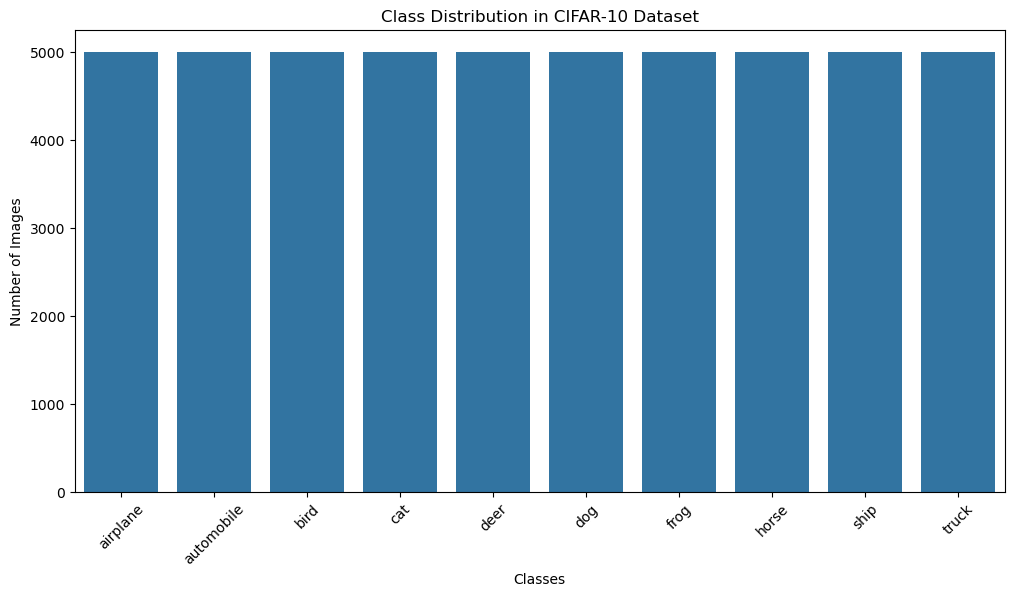

In [4]:
# Plot class distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xticks(ticks=np.arange(10), labels=class_names, rotation=45)
plt.title('Class Distribution in CIFAR-10 Dataset')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.show()

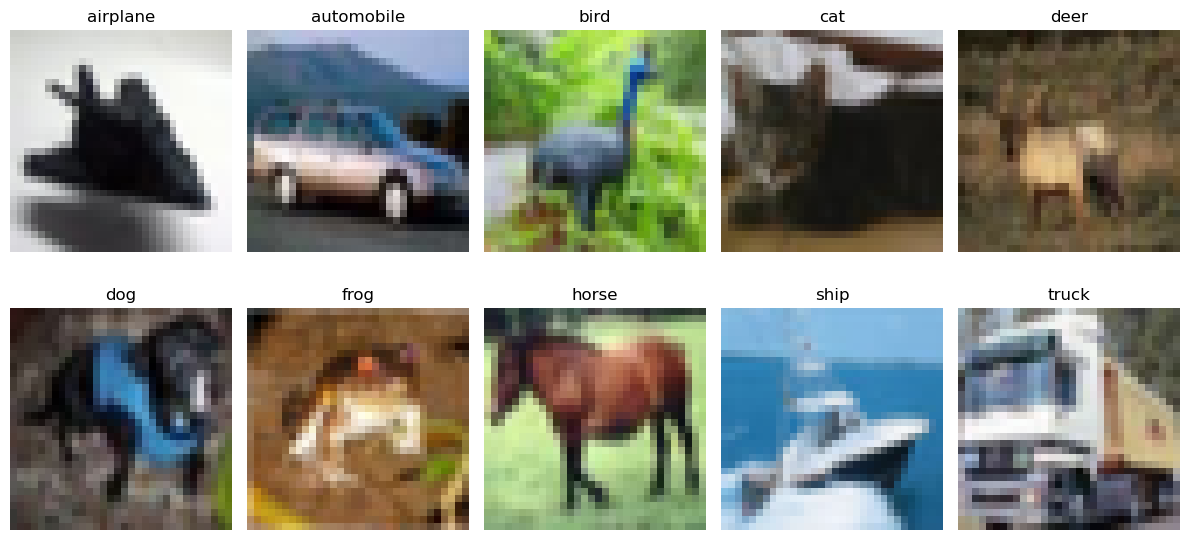

In [5]:

# Function to display sample images from each class
def plot_sample_images(x_data, y_data, class_names):
    plt.figure(figsize=(12, 6))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        idx = np.where(y_data.flatten() == i)[0][0]  # Get the first index for each class
        plt.imshow(x_data[idx])
        plt.title(class_names[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_sample_images(x_train, y_train, class_names)

In [13]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="tensorflow")
warnings.filterwarnings("ignore", category=UserWarning, module="keras")

# Load VGG16 model (pre-trained on ImageNet) without the top fully connected layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Add custom layers on top of the base VGG16 model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling layer
x = Dense(1024, activation='relu')(x)  # Fully connected layer
predictions = Dense(10, activation='softmax')(x)  # Output layer with 10 classes for CIFAR-10

# Define the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the VGG16 base model to avoid re-training them
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(datagen.flow(x_train, y_train, batch_size=64), epochs=10, validation_data=(x_test, y_test))


Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 103ms/step - accuracy: 0.4036 - loss: 1.6684 - val_accuracy: 0.5283 - val_loss: 1.3380
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 80s 102ms/step - accuracy: 0.4976 - loss: 1.4168 - val_accuracy: 0.5536 - val_loss: 1.2600
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 80s 102ms/step - accuracy: 0.5144 - loss: 1.3625 - val_accuracy: 0.5610 - val_loss: 1.2514
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 81s 103ms/step - accuracy: 0.5315 - loss: 1.3269 - val_accuracy: 0.5737 - val_loss: 1.2240
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 81s 104ms/step - accuracy: 0.5357 - loss: 1.3116 - val_accuracy: 0.5837 - val_loss: 1.1871
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 80s 102ms/step - accuracy: 0.5424 - loss: 1.2937 - val_accuracy: 0.5843 - val_loss: 1.1836
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 80s 102ms/step - accuracy: 0.5506 - loss: 1.2686 - val_accuracy: 0.5838 - val_loss: 1.1783
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 80s 102ms/step - accuracy: 0.5559 - loss: 1

In [14]:
# Model evaluation
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {accuracy * 100:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.5968 - loss: 1.1510
Test accuracy: 59.75%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


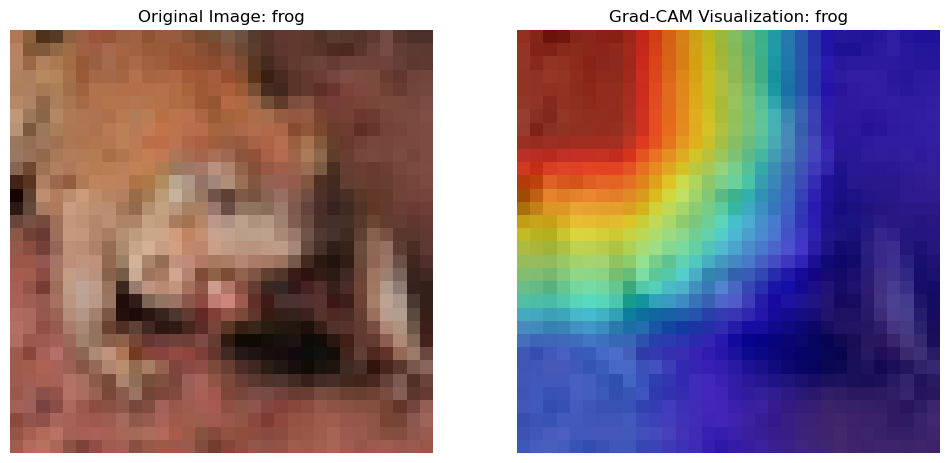

In [25]:

def grad_cam(input_model, image, class_index, layer_name='block5_conv3'):
    # Gradients of the class with respect to the final convolutional layer
    grad_model = Model(inputs=input_model.input, outputs=[input_model.output, input_model.get_layer(layer_name).output])
    
    with tf.GradientTape() as tape:
        model_out, conv_out = grad_model(np.expand_dims(image, axis=0))
        class_channel = model_out[:, class_index]
    
    # Get the gradients of the class output with respect to the feature maps
    grads = tape.gradient(class_channel, conv_out)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
    # Convert conv_out to a NumPy array for modification
    conv_out = conv_out[0].numpy()  # Convert to NumPy array
    pooled_grads = pooled_grads.numpy()  # Ensure this is a NumPy array as well
    
    # Multiply the pooled gradients with the feature map
    for i in range(conv_out.shape[-1]):
        conv_out[:, :, i] *= pooled_grads[i]
    
    # Create heatmap from the feature map
    heatmap = np.mean(conv_out, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    # Resize the heatmap to the size of the input image
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    
    return heatmap

# Select an image to visualize
image_idx = 5  # You can change this index to visualize different images
image = x_test[image_idx]
true_class = y_test[image_idx]

# Make predictions to get the class index
predictions = model.predict(np.expand_dims(image, axis=0))
predicted_class = np.argmax(predictions)

# Generate Grad-CAM heatmap
heatmap = grad_cam(model, image, predicted_class)

# Display original image and Grad-CAM heatmap
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title(f"Original Image: {class_names[true_class[0]]}")
plt.axis('off')

# Grad-CAM heatmap
plt.subplot(1, 2, 2)
plt.imshow(image)
plt.imshow(heatmap, alpha=0.6, cmap='jet')
plt.title(f"Grad-CAM Visualization: {class_names[predicted_class]}")
plt.axis('off')

plt.show()

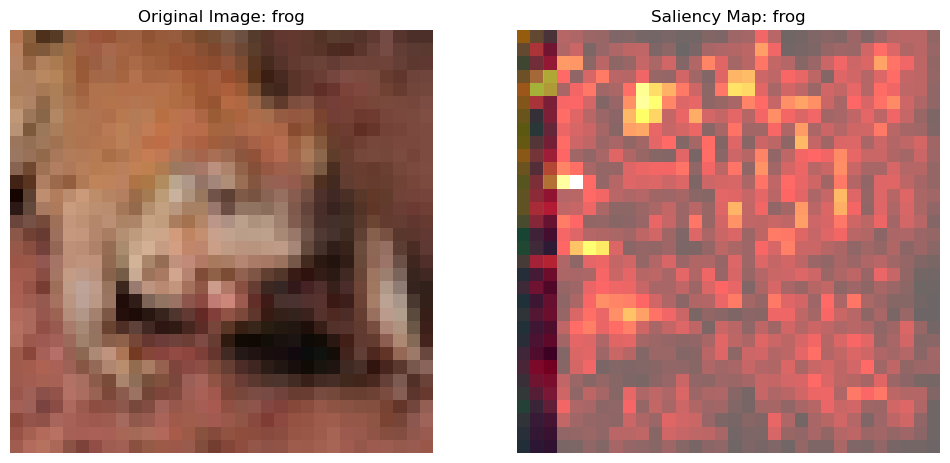

In [30]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Function to display saliency map
def saliency_map(model, image, class_index):
    # Convert the image to a tensor if it's a NumPy array
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    
    # Add batch dimension
    image = tf.expand_dims(image, axis=0)
    
    # Use GradientTape to record the gradient with respect to the image
    with tf.GradientTape() as tape:
        tape.watch(image)  # Watch the image tensor for gradients
        predictions = model(image)  # Get model predictions
        class_channel = predictions[:, class_index]  # Get the predicted class channel
    
    # Get the gradients of the class channel with respect to the image
    grads = tape.gradient(class_channel, image)
    
    # Compute saliency map: maximum absolute gradient per pixel
    saliency = np.max(np.abs(grads), axis=-1)[0]
    
    return saliency

# Example usage
# Assuming you have your `model`, `image`, `predicted_class`, and `class_names` variables set up.

saliency = saliency_map(model, image, predicted_class)

# Display original image and Saliency map
plt.figure(figsize=(12, 6))


# Original Image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title(f"Original Image: {class_names[true_class[0]]}")
plt.axis('off')
# Saliency map
plt.subplot(1, 2, 2)
plt.imshow(image[1])  # Remove batch dimension
plt.imshow(saliency, alpha=0.6, cmap='hot')
plt.title(f"Saliency Map: {class_names[predicted_class]}")
plt.axis('off')

plt.show()
